In [2]:
!pip install scikit-learn
!pip install matplotlib
!pip install pillow
!pip install seaborn



In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = r'D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

C:\Users\User\anaconda3\envs\py310\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ', len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Found 600 images belonging to 4 classes.
Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8807  
Epoch 1: val_accuracy improved from -inf to 0.98667, saving model to best_resnet50_model.h5
88/88 [==============================] - 51s 539ms/step - loss: 0.4831 - accuracy: 0.8807 - val_loss: 0.0559 - val_accuracy: 0.9867
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.1284 - accuracy: 0.9568 
Epoch 2: val_accuracy improved from 0.98667 to 0.98833, saving model to best_resnet50_model.h5
88/88 [==============================] - 44s 498ms/step - loss: 0.1284 - accuracy: 0.9568 - val_loss: 0.0552 - val_accuracy: 0.9883
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9675 
Epoch 3: val_accuracy did not improve from 0.98833
88/88 [==============================] - 42s 474ms/step - loss: 0.0974 - accuracy: 0.967

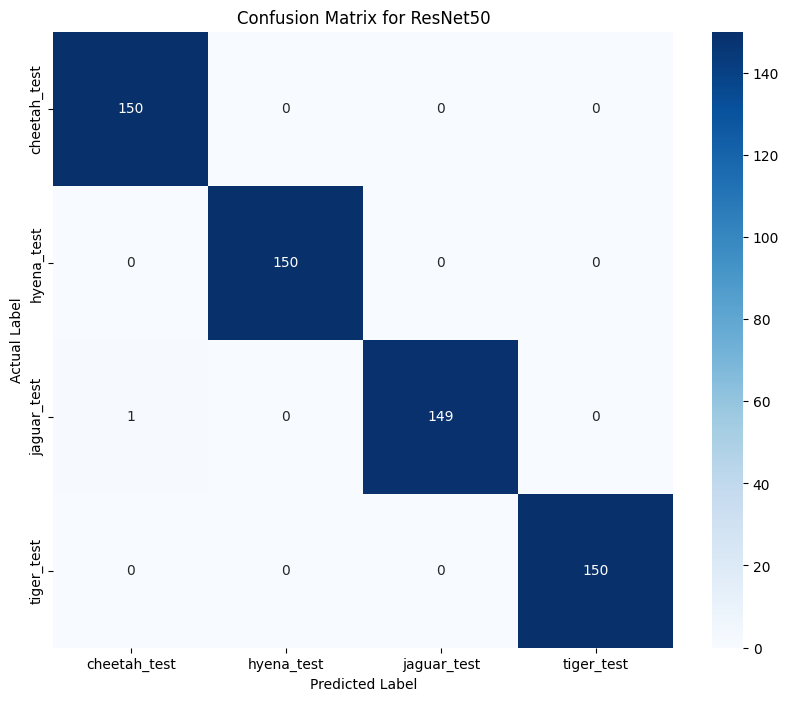

Classification Report for ResNet50
              precision    recall  f1-score   support

cheetah_test       0.99      1.00      1.00       150
  hyena_test       1.00      1.00      1.00       150
 jaguar_test       1.00      0.99      1.00       150
  tiger_test       1.00      1.00      1.00       150

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [78]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, average_precision_score
import matplotlib.pyplot as plt
import time

# Define image dimensions
img_height, img_width = 224, 224
batch_size = 32

# Define paths
base_dir = r'D:\[PC] S E M 6\ISB46703 - PRINCIPLES OF ARTIFICIAL INTELLIGENCE\Project\deep-learning\Dataset'
train_dir = os.path.join(base_dir, 'Train')
val_dir = os.path.join(base_dir, 'Valid')
test_dir = os.path.join(base_dir, 'Test')

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_resnet50_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model
start_time = time.time()
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping]
)
training_time = time.time() - start_time


# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")
print(f"Training Time: {training_time} seconds")

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet50')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report
print('Classification Report for ResNet50')
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))

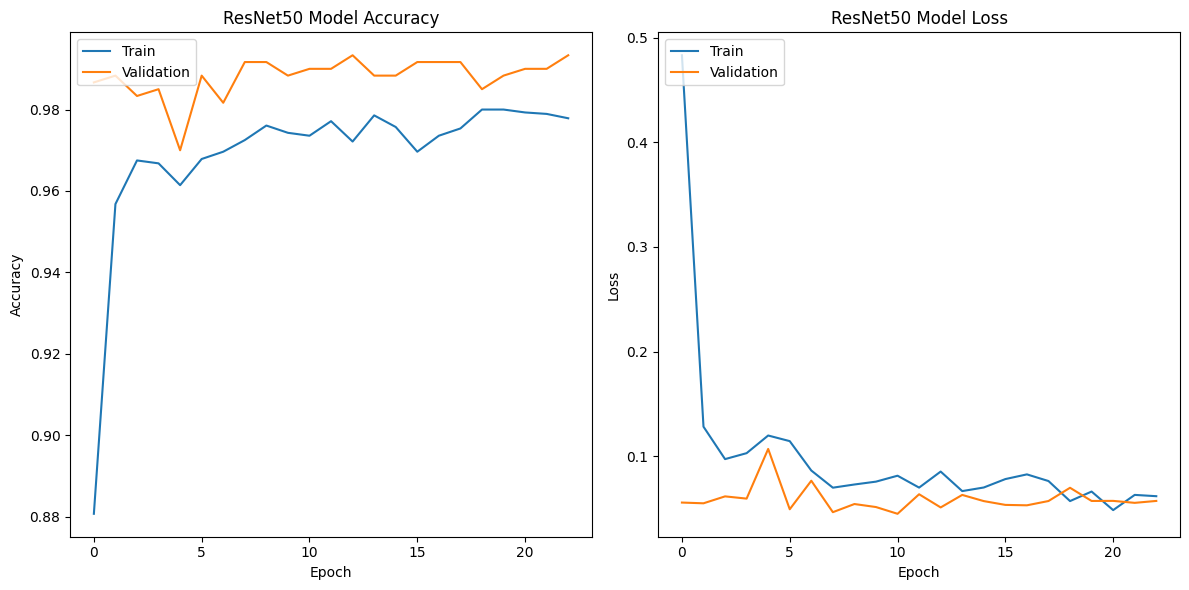

19/19 [==============================] - 3s 97ms/step
Accuracy: 0.9983333333333333
mAP: 0.9999779249448124


In [79]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Load the best model
model = tf.keras.models.load_model('best_resnet50_model.h5')

# Predict using the loaded model
y_pred = model.predict(test_generator)
y_true = test_generator.classes
y_pred_labels = np.argmax(y_pred, axis=1)

# Accuracy and mAP calculation
accuracy = accuracy_score(y_true, y_pred_labels)
mean_ap = average_precision_score(tf.keras.utils.to_categorical(y_true), y_pred)

print(f"Accuracy: {accuracy}")
print(f"mAP: {mean_ap}")